### I have found data containing different economic indicators such as GDP growth, Crude Oil inventories and Natural Gas Storage on various countries. I want to analyze patterns of Crude Oil Inventories over the past 5 years and their impact on 4 asset classes: Transportation equities, Gold prices, TIPS and Exchange Rates. After that, we will conduct asset allocation based on these asset classes using the Risk Parity optimization approach.  

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data as wb

In [4]:
calendar11_13 = pd.read_excel("D2011-13.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
calendar14_18 = pd.read_excel("D2014-18.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
calendar19_20 = pd.read_excel("D2019-20.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
economic_calendar = calendar11_13.append(calendar14_18.append((calendar19_20)))
col_name = ['Time', 'Country','Volatility','Event_desc','Event_eval',
            'Data_format','Actual','Forecast','Previous']
economic_calendar.columns = col_name
economic_calendar.index.names = ['Date']
economic_calendar = economic_calendar.fillna(0)

## Remove white spaces from columns
economic_calendar['Country']=(economic_calendar['Country'].str.strip())
economic_calendar['Volatility']=(economic_calendar['Volatility'].str.strip())
economic_calendar['Event_desc']=(economic_calendar['Event_desc'].str.strip())
economic_calendar['Event_eval']=(economic_calendar['Event_eval'].str.strip())

## Lets work with US Data
US_data = economic_calendar[economic_calendar['Country']=="United States"]
US_data.head()

,Time,Country,Volatility,Event_desc,Event_eval,Data_format,Actual,Forecast,Previous
Date,,,,,,,,,
2011-01-01,04:00:00,United States,Moderate Volatility Expected,10-Year Note Auction,NaN,%,3.38,,2.63
2011-01-01,04:00:00,United States,Low Volatility Expected,3-Month Bill Auction,NaN,%,0.18,,0.18
2011-01-01,04:00:00,United States,Low Volatility Expected,3-Year Note Auction,NaN,%,0.73,,0.5
2011-01-01,04:00:00,United States,Low Volatility Expected,30-Year Bond Auction,NaN,%,4.25,,4.25
2011-01-01,04:00:00,United States,Low Volatility Expected,5-Year Note Auction,NaN,%,2.13,,1.38


### 1 - Analyze Crude Oil Inventories data

In [5]:
# Lets work with Crude Oil Inventories using the historical data that we have. 
# Lets search for wherever 'Crude Oil Inventories' has been used in our dataset 
# and then subset the data based on that for the analysis.
oil_entries = [c for c in US_data["Event_desc"] if 'Crude Oil Inventories' in c]

## Count frequency of top Crude Oil Inventories indicators found in the dataset for US
oil_ds = pd.Series(oil_entries)
oil_ds.value_counts().head()

Crude Oil Inventories            483
Cushing Crude Oil Inventories    221
dtype: int64

In [7]:
# Subset data based on Crude Oil Inventories and analyze patterns
# Create a new function: func to see how actual performance is compared with forecasted or previous performance. 
# We have given a value of -10 for na values
us_oil_data = US_data[US_data["Event_desc"].isin(oil_entries)]

def func(row):
    if row['Event_eval'] == 'Worse Than Expected':
        val = -1
    elif row['Event_eval'] == 'In Line with Expectation':
        val = 0
    elif row['Event_eval'] == 'Better Than Expected':
        val = 1
    else:
        val = -10
    return val

# The table for this code will have values for "Crude Oil Inventories" and for "Cushing Crude Oil Inventories".
us_oil_data['Comparison'] = us_oil_data.apply(func, axis=1)

# However we just need a table for "Crude Oil Inventories".
us_crude = us_oil_data[us_oil_data["Event_desc"]=="Crude Oil Inventories"]
us_crude.head()

C:\Users\aleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Time,Country,Volatility,Event_desc,Event_eval,Data_format,Actual,Forecast,Previous,Comparison
Date,,,,,,,,,,
2011-01-05,10:30:00,United States,High Volatility Expected,Crude Oil Inventories,Worse Than Expected,M,-4.2,-1.4,-1.3,-1
2011-01-12,10:30:00,United States,High Volatility Expected,Crude Oil Inventories,Worse Than Expected,M,-2.2,0.4,-4.2,-1
2011-01-20,11:00:00,United States,High Volatility Expected,Crude Oil Inventories,Better Than Expected,M,2.6,-1.1,-2.2,1
2011-01-26,10:30:00,United States,High Volatility Expected,Crude Oil Inventories,Better Than Expected,M,4.8,1.25,2.6,1
2011-02-02,10:30:00,United States,High Volatility Expected,Crude Oil Inventories,Better Than Expected,M,2.6,2.5,4.8,1


In [8]:
# US Crude Oil weekly data
us_crude_weekly = pd.DataFrame(us_crude[["Actual", "Forecast", "Previous", "Comparison"]], 
                               columns = ["Actual", "Forecast", "Previous", "Comparison"])
us_crude_weekly.head()

,Actual,Forecast,Previous,Comparison
Date,,,,
2011-01-05,-4.2,-1.4,-1.3,-1
2011-01-12,-2.2,0.4,-4.2,-1
2011-01-20,2.6,-1.1,-2.2,1
2011-01-26,4.8,1.25,2.6,1
2011-02-02,2.6,2.5,4.8,1


In [9]:
# Resample to compute US Crude Oil Inventory monthly data from weekly data
def monthly_resampling(comparison):
    return comparison.sum()

us_crude_monthly = us_crude_weekly.resample('M').apply(monthly_resampling).to_period('M')
us_crude_monthly.head()

,Actual,Forecast,Previous,Comparison
Date,,,,
2011-01,1.0,-0.85,-5.1,0
2011-02,6.2,7.65,10.2,-2
2011-03,8.8,8.00,6.7,1
2011-04,7.5,4.50,4.2,2
2011-05,7.8,2.90,13.4,2


Text(0.5, 1.0, 'Actual Performance of US Crude Oil Inventories vs Forecasted and Previous')

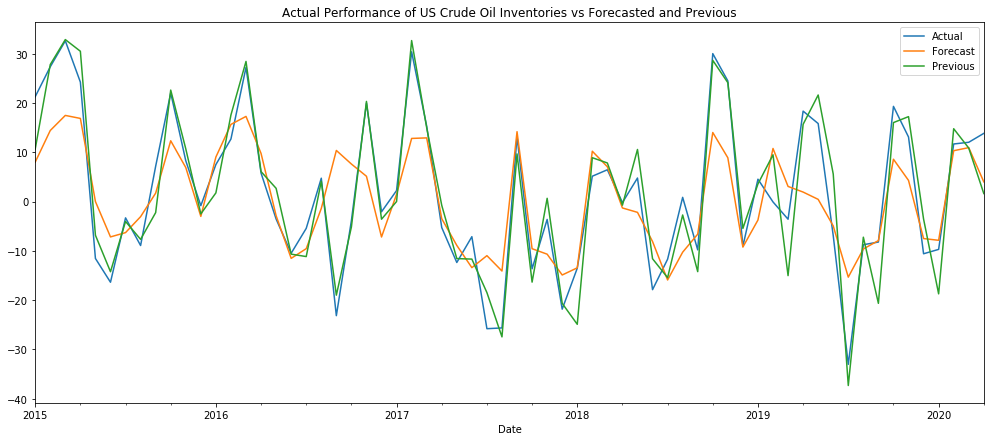

In [10]:
# One of the most popular indicators used by oil traders is the crude inventories (stock levels), 
# which is the amount of oil currently stored for future use. It gives traders an idea of the trends in production
# and consumption of oil over a specific period of time, and lets them gain insight into future moves of oil prices.
# In the graph below, Forecasted inventories are conservative compared to Actual and Previous levels. This shows that either 
# supply levels are moving faster than expected and/ or demand levels are moving slower than expected.
# Actual levels are mostly the same as Previous levels over the previous years showing consistency.
# Demand has slowly increased from the 2016 oil crash, as can be seen from the downward trend in graph of oil inventories

us_crude_monthly[["Actual", "Forecast", "Previous"]]["2015":].plot(figsize=(17,7))
plt.title("Actual Performance of US Crude Oil Inventories vs Forecasted and Previous")

Text(0.5, 1.0, 'Actual Performance of US Crude Oil Inventories vs Forecasted')

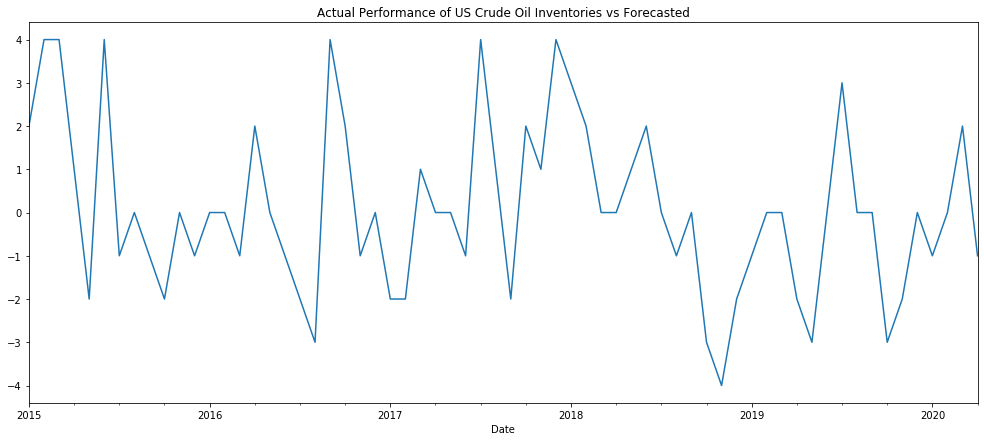

In [11]:
# In the graph below, numbers above 0 signify better than expected performance of oil inventories. 
# For instance, in 2015Q1, level is at +4, showing that there was more Actual inventory compared to Forecasted.
# This could mean production outstripped demand. Traders may question the demand for oil at the current price and 
# immediately sell their positions, causing a price retreat.
# We notice that from Q3 (Fall) to mid-Q4 of each year, crude oil inventory numbers are negative, showing strong demand, 
# that would imply higher prices. 
# Mid-Q4 onwards up until Q1, crude oil inventories start moving up, meaning demand is slowing down during the winter months.

us_crude_monthly["Comparison"]["2015":].plot(figsize=(17,7))
plt.title("Actual Performance of US Crude Oil Inventories vs Forecasted")

### 2 - Load up ETF data for transportation companies (IYT) from Yahoo finance. Analyze impact of Crude Oil Inventories 

Text(0.5, 1.0, 'US Transportation ETF (IYT) price data with 200-day Simple Moving Average')

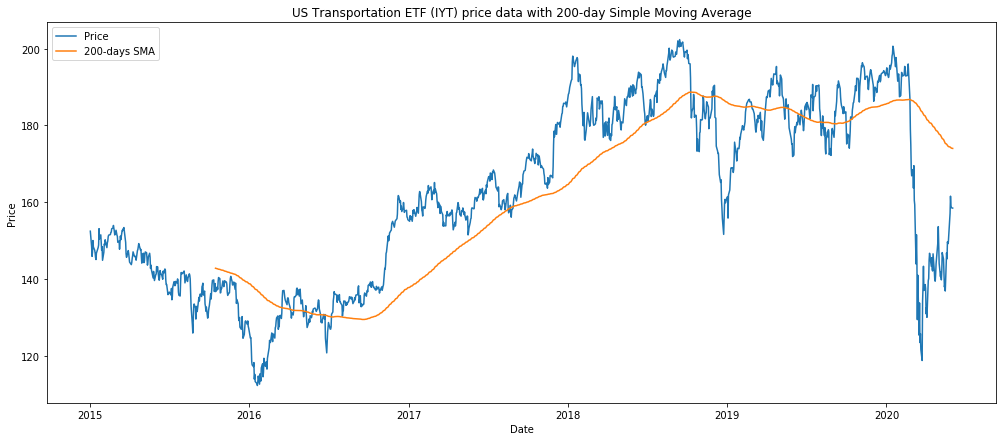

In [13]:
# There is little correlation between oil prices and the stock market, and hence we cant really predict the way stocks will 
# react to changing oil inventories or prices. Oil prices do have an impact on the U.S. economy, but it goes two ways 
# because of the diversity of industries. High oil prices can drive job creation and investment as it becomes economically
# viable for oil companies to exploit higher-cost shale oil deposits. However, high oil prices also hit businesses and 
# consumers with higher transportation and manufacturing costs. One sector of the stock market is strongly correlated 
# with the spot price of oil: transportation. This makes sense because the dominant input cost for transportation firms is fuel.

assets = ['IYT']
stock_prices = pd.DataFrame()
for a in assets:
    stock_prices[a] = wb.DataReader(a, data_source = 'yahoo', start = '2015-01-01', end = '2020-06-01')['Adj Close']

# Plot S&P500 price data along with its 200-day Simple-Moving average    
sm_sma = stock_prices.rolling(window=200).mean()
fig, ax = plt.subplots(figsize=(17,7))
ax.plot(stock_prices.index, stock_prices, label='Price')
ax.plot(sm_sma.index, sm_sma, label = '200-days SMA')
ax.legend(loc='best')
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title("US Transportation ETF (IYT) price data with 200-day Simple Moving Average")

### 3- Lets load up an ETF for gold (GLD) where the underlying assets consist of gold bars stored in secure vaults. As such, the price of this ETF can be expected to move in lock step with spot gold prices

Text(0.5, 1.0, 'Gold price data with 200-day Simple Moving Average')

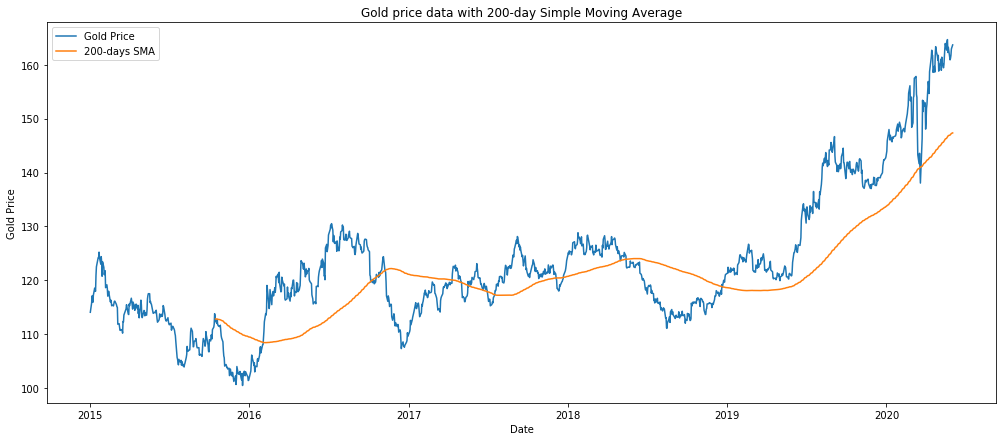

In [17]:
# Low oil inventories would signal that demand outstrips production leading to higher oil prices. High oil prices increase 
# the costs of making and transporting goods, driving consumer prices higher. Holding gold is one way of protecting against 
# inflation. So higher oil prices will frequently lead to a similar rise in gold. Higher oil prices can also mean the economy 
# is doing well and investors go for equities rather than gold, so its difficult to assess the relationship between oil 
# inventories and gold prices.
# When the markets are nervous, investors tend to turn to gold, which is considered one of the safest assets. A higher risk 
# environment in the world of energy frequently translates into higher demand for gold.

gold = ['GLD']
gold_prices = pd.DataFrame()
for g in gold:
    gold_prices[g] = wb.DataReader(g, data_source = 'yahoo', start = '2015-01-01', end = '2020-06-01')['Adj Close']

gp_sma = gold_prices.rolling(window=200).mean()
fig, gp = plt.subplots(figsize=(17,7))
gp.plot(gold_prices.index, gold_prices, label='Gold Price')
gp.plot(gp_sma.index, gp_sma, label = '200-days SMA')
gp.legend(loc='best')
gp.set_xlabel("Date")
gp.set_ylabel("Gold Price")
gp.set_title("Gold price data with 200-day Simple Moving Average")

### 4- Load up Treasury Inflated Protected Securities (TIPS) data from Yahoo Finance

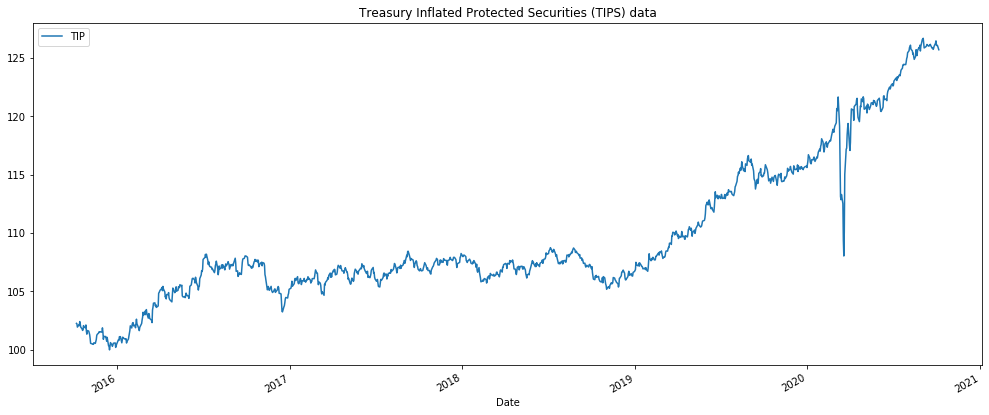

In [22]:
# Treasury inflation-protected securities (TIPS) are a type of Treasury security issued by the U.S. government. 
# TIPS are indexed to inflation in order to protect investors from a decline in the purchasing power of their money. 
# As inflation rises, TIPS adjust in price to maintain its real value

assets_4 = ['TIP']
tips = pd.DataFrame()
for a in assets_4:
    tips[a] = wb.DataReader(a, data_source = 'yahoo')['Adj Close']
tips.plot(figsize=(17,7), title = 'Treasury Inflated Protected Securities (TIPS) data')

### 5- Load up Currency exchange data (CAD to USD) and see if Crude Oil Inventories have any impact on it

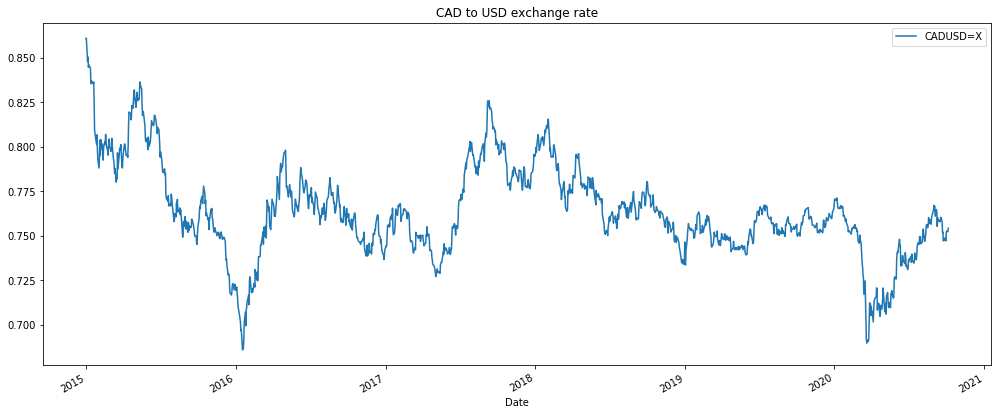

In [20]:
# These movements are less correlated in nations without significant crude oil reserves, like Japan, and more correlated 
# in nations that have significant reserves like Canada, Russia, and Brazil. The currency of the country is affected by the 
# commodity it exports. 

assets_4 = ['CADUSD=X']
currency_exch = pd.DataFrame()
for a in assets_4:
    currency_exch[a] = wb.DataReader(a, data_source = 'yahoo', start = '2015-01-01')['Adj Close']
currency_exch.plot(figsize=(17,7), title = 'CAD to USD exchange rate')

### 6- Summary statistics for these 4 asset classes

In [25]:
# Download the price data for these 4 asset classes again from Yahoo Finance, but merge them now
tickers = ['IYT', 'GLD', 'TIP', 'CADUSD=X']
riskparity_pf = pd.DataFrame()
for t in tickers:
    riskparity_pf[t] = wb.DataReader(t, data_source = 'yahoo', start = '2015-01-01')['Adj Close']
riskparity_pf.head()

,IYT,GLD,TIP,CADUSD=X
Date,,,,
2015-01-02,152.484985,114.080002,102.914795,0.861030
2015-01-05,148.461166,115.800003,102.996948,0.847961
2015-01-06,145.931091,117.120003,103.006134,0.850557
2015-01-07,147.014084,116.430000,103.088242,0.844809
2015-01-08,150.057648,115.940002,102.923943,0.846131


In [26]:
# First compute monthly returns for them 
def compound_ret(r):
    return np.exp(np.log(1+r).sum()) - 1

riskparity_dr = riskparity_pf.pct_change() 
riskparity_mr = riskparity_dr.resample('M').apply(compound_ret).to_period('M')
riskparity_mr.head()

,IYT,GLD,TIP,CADUSD=X
Date,,,,
2015-01,-0.049654,0.082135,0.025725,-0.079131
2015-02,0.045484,-0.059052,-0.012886,0.008718
2015-03,-0.032051,-0.021522,-0.004819,-0.014581
2015-04,-0.016856,-0.001672,0.006779,0.050505
2015-05,-0.031433,0.005552,-0.010056,-0.027935


In [33]:
# Functions for Annualized mean, volatility, sharpe ratio, drawdowns and Value at Risk
import scipy.stats 
from scipy.stats import norm

def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

# Calculate Value at Risk, which tells you the maximum expected loss we can take in 95% of the time over a given time period
def var_gaussian(r, level=5, modified=False):
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = scipy.stats.skew(r)
        k = scipy.stats.kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [35]:
# Put them all into one function/ table to make it presentable

def summary_stats(r, riskfree_rate=0.02):
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(scipy.stats.skew)
    kurt = r.aggregate(scipy.stats.kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

summary_stats(riskparity_mr)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Sharpe Ratio,Max Drawdown
IYT,0.050603,0.200459,-0.709979,0.870560,0.102204,0.149746,-0.308759
GLD,0.080710,0.140680,0.386757,0.144169,0.056809,0.423685,-0.178129
TIP,0.034880,0.037336,0.289862,-0.160775,0.014467,0.391342,-0.048299
CADUSD=X,-0.022768,0.080893,-0.229592,0.821144,0.042292,-0.519234,-0.142066


### 7 - Asset allocation with these 4 asset classes based on the Risk Parity approach

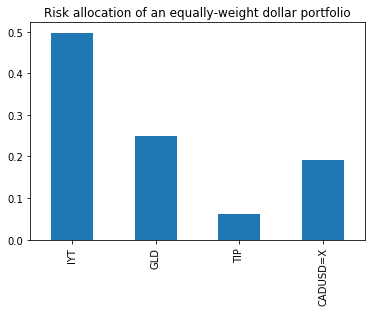

In [36]:
# Risk parity portfolios allocate equal amounts of risk for each stock towards the overall risk of the portfolio. 
# For instance, if we have a 5 stock portfolio, each of these will allocate 20% of risk. 
# Based on this, we find the optimal weights in terms of dollar amounts which we invest in each of those stocks. 
# This is a sophisticated diversification technique that focuses on risk analysis.

cov = riskparity_mr.cov()

# Equal-weights function
def equal_weights(rets):
    n = len(rets.columns)
    weights = pd.Series(1/n, index = rets.columns)
    return weights

# Portfolio Volatility
def pf_vol(weights, cov):
    return (weights.T @ cov @ weights)**0.5

# Risk-contributions for each asset towards the overall portfolio volatility
def risk_cont(weights, cov):
    pf_volatility = pf_vol(weights, cov) ** 2
    risk = cov@weights
    risk_contribution = np.multiply(risk, weights.T)/pf_volatility
    return risk_contribution

# Lets first find the risk-contributions for an equally-weighted dollar portfolio to see how risk is allocated.
risk_cont(equal_weights(riskparity_mr), cov).plot.bar(title = "Risk allocation of an equally-weight dollar portfolio")

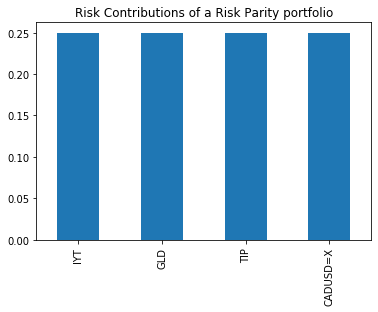

In [37]:
from scipy.optimize import minimize

# Find optimal dollar weights such that the risk-contributions meet a target contribution level, 
# in this case being 1/n = 0.2 for each asset class

def t_risk_cont(t_risk, cov):
    n = cov.shape[0]
    initial_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n
    weights_constraint = {'type': 'eq',
                         'fun': lambda weights: np.sum(weights) - 1}
    def msd(weights, t_risk, cov):
        contributions = risk_cont(weights, cov)
        return ((contributions - t_risk)**2).sum()
    
    weights = minimize(msd, initial_guess,
                       args=(t_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_constraint,),
                       bounds=bounds)
    return weights.x

def equal_risk_cont(cov):
    n = cov.shape[0]
    return t_risk_cont(np.repeat(1/n, n), cov)

# Risk-parity allocation levels for risk. We see that they are equal i.e 0.25
risk_cont(equal_risk_cont(cov), cov).plot.bar(title="Risk Contributions of a Risk Parity portfolio")

In [38]:
# Find optimal dollar weights to put in each asset class based on the above risk-allocation levels of 0.25

def sample_covariance(rets):
    return rets.cov()

def weight_rp(rets):
    est_cov = sample_covariance(rets)
    return equal_risk_cont(est_cov)

pd.DataFrame(weight_rp(riskparity_mr) * 100, index = riskparity_mr.columns, columns = ["Weight"])

,Weight
IYT,10.975451
GLD,14.325238
TIP,51.461973
CADUSD=X,23.237339
